In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/My\ Drive/Deep\ RL

/content/drive/My Drive/Deep RL


# Choice of features and Number of Layers

In the data exploration section, it has been found that there is a huge correlation between the first principal component direction and the annotations. Since the value of feature along a principal component is a linear combination of its features, a two layer neural network should do a decent job a seperating the chunk of blue points on the left hand side from the pink points on the right hand side. Hence, all of these features will be used.

Obviously, we are not using sample code number as a feature choice because it is completely arbitary and has not correlation with the annotations.

# Prevent Overfitting

Since we have little data, regularisation is important. I plan on using the following techniques:
1. Drop Out
2. Weight Decay
3. Small batch size (During training)
4. Momentum with SGD
5. Early Stopping

Since I do not have professional knowledge on cancer detection, I will not attmept to augment the data.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline

# Read Input

In [ ]:
f_name = 'breast-cancer-wisconsin.data'
df = pd.read_csv(f_name, header=None)
df = df.apply(pd.to_numeric, errors='coerce')
print(df)

          0   1   2   3   4   5     6   7   8   9   10
0    1000025   5   1   1   1   2   1.0   3   1   1   2
1    1002945   5   4   4   5   7  10.0   3   2   1   2
2    1015425   3   1   1   1   2   2.0   3   1   1   2
3    1016277   6   8   8   1   3   4.0   3   7   1   2
4    1017023   4   1   1   3   2   1.0   3   1   1   2
..       ...  ..  ..  ..  ..  ..   ...  ..  ..  ..  ..
694   776715   3   1   1   1   3   2.0   1   1   1   2
695   841769   2   1   1   1   2   1.0   1   1   1   2
696   888820   5  10  10   3   7   3.0   8  10   2   4
697   897471   4   8   6   4   3   4.0  10   6   1   4
698   897471   4   8   8   5   4   5.0  10   4   1   4

[699 rows x 11 columns]


# Convert to Numpy and Verify

In [ ]:
values = df.values
X = values[:, 1:10].astype(np.float32)
X[np.isnan(X)] = 0 # Replace nan values with 0, so they will have no influence over the neural network

Y = values[:, 10].astype(np.float32)
#One hot encoding
Y[Y == 4] = 1
Y[Y == 2] = 0

In [ ]:
print(f"X.shape = {X.shape}\nY.shape = {Y.shape}")
print(f"X[0, :] = {X[0, :]}\nY[0] = {Y[0]}")

X.shape = (699, 9)
Y.shape = (699,)
X[0, :] = [5. 1. 1. 1. 2. 1. 3. 1. 1.]
Y[0] = 0.0


# Data Exploration

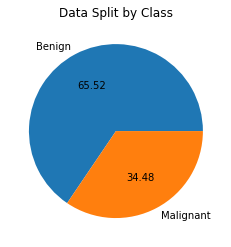

In [ ]:
def count_benign(annotations):
  return np.count_nonzero(annotations == 0)
def count_malignent(annotations):
  return np.count_nonzero(annotations == 1)

def generate_pie_chart_annotations(annotations):
  num_benign = count_benign(annotations)
  num_malignent = count_malignent(annotations)

  plt.pie([num_benign, num_malignent], labels=["Benign", "Malignant"], autopct='%.2f')
  plt.title("Data Split by Class")
  plt.show()

generate_pie_chart_annotations(Y)

Surprisingly, the data is reasonably balanced. I had suspected that the number of malignant data points would be very less compared to the number of benign data points since malignant data points are relatively rare.

In [ ]:
from sklearn.decomposition import PCA

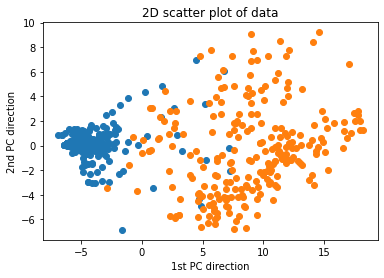

In [ ]:
def gen_pca_scatter_plot(input, label):
  pca_obj = PCA(n_components=2)
  pca_obj.fit(input)
  input_dim_2 = pca_obj.transform(input)
  
  plt.title("2D scatter plot of data")
  x = input_dim_2[Y == 0]
  plt.scatter(x[:, 0], x[:, 1], label="Benign")
  x = input_dim_2[Y == 1]
  plt.scatter(x[:, 0], x[:, 1], label="Malignant")

  plt.xlabel("1st PC direction")
  plt.ylabel("2nd PC direction")
  plt.show()

gen_pca_scatter_plot(X, Y)

Note the significant correlation between the annotations and first principal direction

# Create dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TinyDataset(Dataset):
  def __init__(self, X, Y, indices):
    self.X = X[indices]
    self.Y = Y[indices]

  def __len__(self):
    return len(self.Y)
    
  def __getitem__(self, idx):
    return torch.from_numpy(self.X[idx]), torch.from_numpy(np.asarray(self.Y[idx]))

In [ ]:
num_data_points = len(Y)
num_val_test = num_data_points//7

shuffle_indices = np.arange(num_data_points)
test_indices = shuffle_indices[-num_val_test:]
val_indices = shuffle_indices[-2*num_val_test:-num_val_test]
train_indices = shuffle_indices[:-2*num_val_test]

train_loader = DataLoader( TinyDataset(X, Y, train_indices), shuffle=True, batch_size=32)
val_loader = DataLoader( TinyDataset(X, Y, val_indices), shuffle=False, batch_size=256)
test_loader = DataLoader( TinyDataset(X, Y, test_indices), shuffle=False, batch_size=256)


# Create Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

model = nn.Sequential(
    nn.Linear(9, 5),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-10)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

device = cuda:0


# Train and Validate Model

In [ ]:
def train_loop(model_train, loader, opt, device):
  model_train.train()
  total_loss = 0.0
  for data, target in loader:
    data, target = data.to(device), target.to(device)

    opt.zero_grad()
    output = model_train(data)
    output = output.squeeze(1)
    loss = F.binary_cross_entropy(output, target)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()*len(data)
  return total_loss/len(loader.dataset)

def val_loop(model_val, loader, device):
  model_val.eval()
  total_loss = 0.0
  for data, target in loader:
    data, target = data.to(device), target.to(device)

    with torch.no_grad():
      output = model_val(data)
      output = output.squeeze(1)
      loss = F.binary_cross_entropy(output, target)
    total_loss += loss.item()*len(data)

  return total_loss/len(loader.dataset)

def test_loop(model_test, loader, device):
  model_test.eval()
  total_correct = 0
  for data, target in loader:
    data, target = data.to(device), target.to(device)

    with torch.no_grad():
      output = model_test(data)
    output = output.squeeze(1)
    pred = torch.round(output)
    total_correct += pred.eq(target).sum().item()

  return 100*total_correct/len(loader.dataset)


In [ ]:
def plot_losses(train, val, stopped_epoch):
  N = len(train)
  X = np.arange(N)

  plt.title("Train/Val Loss over epochs")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.xscale("log")

  plt.plot(X, train, label = "Training Loss")
  plt.plot(X, val, label = "Validation Loss")

  plt.axvline(x=stopped_epoch, ymin=0, ymax=1, color="black")

  plt.legend()

  plt.show()

import copy

def train_and_evaluate_model(model, opt, sch, device, num_epochs):
  train_losses = []
  val_losses = []

  best_val_loss = float("inf")
  best_epoch = -1
  best_state = None

  for epoch in range(num_epochs):
    train_loss = train_loop(model, train_loader, optimizer, device)
    val_loss = val_loop(model, val_loader, device)
  
    sch.step()

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_epoch = epoch
      best_state = copy.deepcopy(model.state_dict())

    train_losses.append(train_loss)
    val_losses.append(val_loss)

  model.load_state_dict(best_state)
  return train_losses, val_losses, best_epoch

In [ ]:
train_losses, val_losses, stopped_epoch = train_and_evaluate_model(model, optimizer, scheduler, device, 3000)

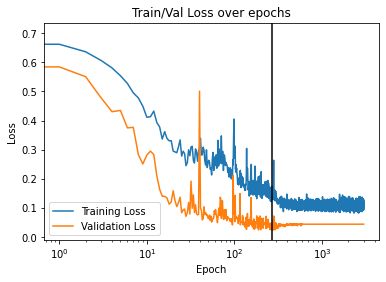

Final Train Loss = 0.0988597877308756
Final Validation Loss = 0.04373371601104736
Early Stopped Epoch = 268
Early Stopped Train Loss = 0.16787801400392116
Early Stopped Loss = 0.02332250215113163


In [ ]:
plot_losses(train_losses, val_losses, stopped_epoch)
print(f"Final Train Loss = {train_losses[-1]}")
print(f"Final Validation Loss = {val_losses[-1]}")
print(f"Early Stopped Epoch = {stopped_epoch}")
print(f"Early Stopped Train Loss = {train_losses[stopped_epoch]}")
print(f"Early Stopped Loss = {val_losses[stopped_epoch]}")

In [ ]:
final_acc = test_loop(model, test_loader, device)
print(f"Final Test Accuracy = {final_acc}%")

Final Test Accuracy = 100.0%


In [ ]:
torch.save(final_model.state_dict(), "model.pth")